# Problem Statement

Much work on sentiment analysis has been done on short-form text data such as those derived from micro-blogging social media sites. Because of the succinct nature of these social media posts, it is perhaps easier to glean points of view than from longer pieces of text.
I would therefore like to perform sentiment parsing of long-form text in the form of book reviews. 

I will use book reviews scraped from various websites including Goodreads stored on Kaggle as CSV files. The goal is to use different machine learning models to parse sentiment (either positive or negative) from each review. For this supervised classification problem, I will compare the performance of a Long Short Term Memory neural network (notebook c.) and Recurrent Neural Network (notebook d.) to a Naive Bayes model (notebook b.)

## Exploratory Data Analysis

In [1]:
from __future__ import print_function
%matplotlib inline

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import spacy
import en_core_web_sm
import unicodedata

import re
import string

import funcs

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
nlp = en_core_web_sm.load()

In [3]:
reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "book_reviews.csv")

df1 = funcs.load_data(reviews_path)
assert df1.shape == (2808, 2)

In [4]:
reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "review.csv")

df2 = funcs.load_data2(reviews_path) 

assert df2.shape == (460, 2)


In [5]:
#concatenating both dataframes
frames = [df1, df2]
df = pd.concat(frames)
df.shape

(3268, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3268 entries, 0 to 459
Data columns (total 2 columns):
text     3268 non-null object
label    3268 non-null int64
dtypes: int64(1), object(1)
memory usage: 76.6+ KB


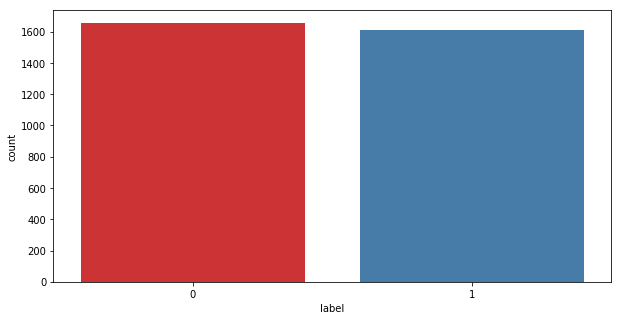

In [7]:
funcs.plot_df(df)

In [8]:
df.label.value_counts()

0    1656
1    1612
Name: label, dtype: int64

The final dataframe has roughly equal counts of labels (0 indicating negative sentiment, 1 indicating positive sentiment).

## Preprocessing

In [9]:
df['text'] = [funcs.remove_accented_chars(sent) for sent in df['text']]


In [10]:
df['text'] = [funcs.lemmatize_text(sent) for sent in df['text']]

In [11]:
df['text'] = [funcs.remove_special_characters(sent) for sent in df['text']]

In [12]:
df.head()

,text,label
0,fascinating view into the past this book be f...,1
1,a very amusing look at the past I be hope for...,1
2,do not like I do not like this version of th...,0
3,two diva that should shut up here be two so...,0
4,Movie Version be much well the movie version...,0


In [13]:
df.tail()

,text,label
455,a second chance story full of suspense traged...,1
456,a lovely wordless picture book with endearing ...,1
457,I be glad a gay writer win the Pulitzer for wr...,0
458,good world and interesting story but the chara...,0
459,sex pair of hand and love time 10laura be sho...,1


In [14]:
# Remove extra white-space from text
df['text'] = [re.sub(' +', ' ', sent) for sent in df['text']]

In [15]:
df.head()

,text,label
0,fascinating view into the past this book be fa...,1
1,a very amusing look at the past I be hope for ...,1
2,do not like I do not like this version of the ...,0
3,two diva that should shut up here be two songb...,0
4,Movie Version be much well the movie version o...,0


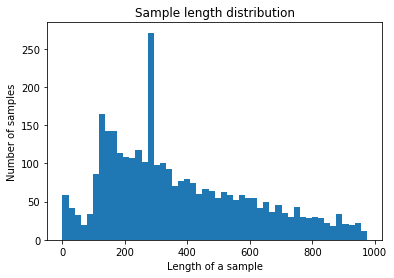

In [17]:
funcs.plot_sample_length_distribution(df['text'])

In [18]:
#Obtains the average, minimum and maximum review lengths
lens = df['text'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())


373.1842105263158 229.92611042475045 0 974


Most reviews contain around 370 words. The longest review contains 974 words and the shortest review containing no words. The text in this dataset seems to be longer than most social media texts used for sentiment analysis. For comparison, posts on the social media website Twitter which imposes a character limit contain an average of 33 characters.

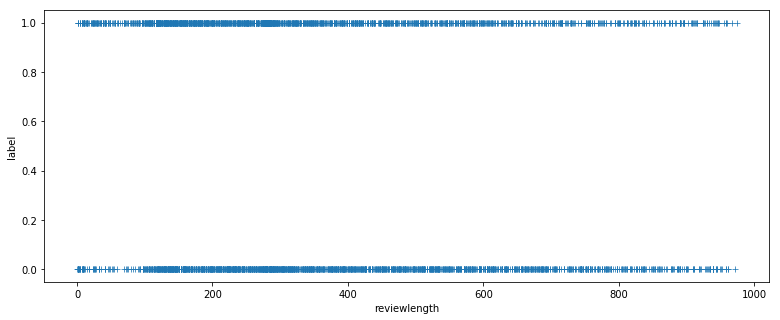

In [19]:
df['reviewlength'] = df['text'].apply(lambda x: len(x))
data = df.sort_values(by='reviewlength')
plt.figure(figsize = (13, 5))
_ = sns.scatterplot(x="reviewlength", y="label", data=data, marker="+")


The scatter plot above is to visualize whether longer reviews were more likely to be rated positive/ negative reviews compared to the shorter reviews. The plot shows no distinguishable relationship between the length of a review and its likelihood to be positive or negative. 

In [20]:
# Extracting all text and joining all words in preparation for wordcloud
text = " ".join(review for review in df.text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 1222833 words in the combination of all review.


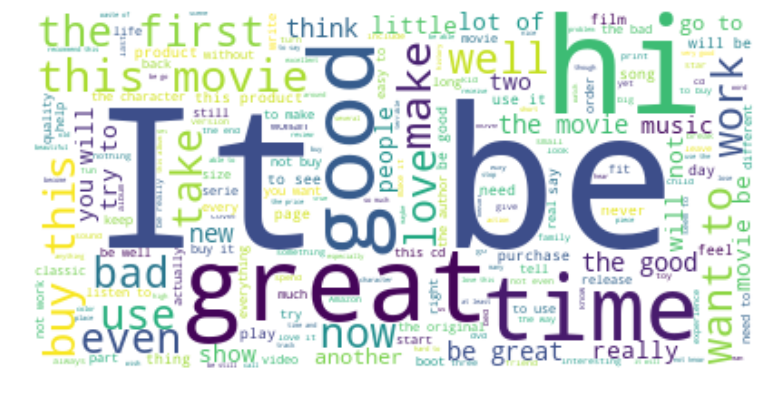

In [21]:
#visualizing all text in wordcloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.update(["this", "thi", "book", "one", "to", "it", "be", "It", "the", "novel", "story", "read"])

wordcloud1 = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(1, figsize=(13, 13))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()


While the word cloud is not very effective at removing all stopwords, it shows that most reviews have positive words including "good" and "great". It is worth investigating whether there's a clear distinction in the word cloud visualization between negative and positive rated reviews below.

In [22]:
#Extracting positive rated reviews and storing them in a new dataframe
df_pos = df[ df['label'] == 1]
df_pos = df_pos['text']
df_pos.head()

0    fascinating view into the past this book be fa...
1    a very amusing look at the past I be hope for ...
5    the SONG be soulful u are one of the BEST sing...
6    wuzzup Mariah I be Kaligirl from Seoul when Yo...
8     when you believe this song sing by Whitney Ho...
Name: text, dtype: object

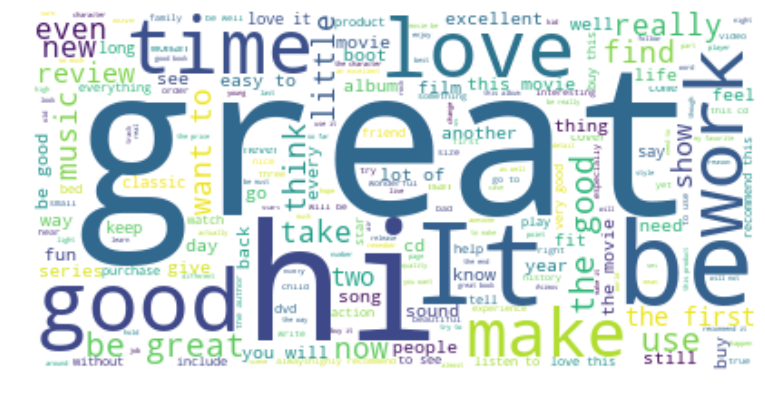

In [23]:
wordcloud2 = WordCloud(stopwords=stopwords, background_color='white').generate(" ".join(df_pos))
plt.figure(1, figsize=(13, 13))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

The most prominent words in the positive reviews are largely positive as is expected with the words “great” and “good” crowding out the rest of the words in the visualization.

In [24]:
#Extracting negative rated reviews and storing them in a new dataframe
df_neg = df[ df['label'] == 0]
df_neg = df_neg['text']
df_neg.head()

2     do not like I do not like this version of the ...
3     two diva that should shut up here be two songb...
4     Movie Version be much well the movie version o...
7     New Age the song be sung beautifully but be it...
14    impressive character development but mostly mo...
Name: text, dtype: object

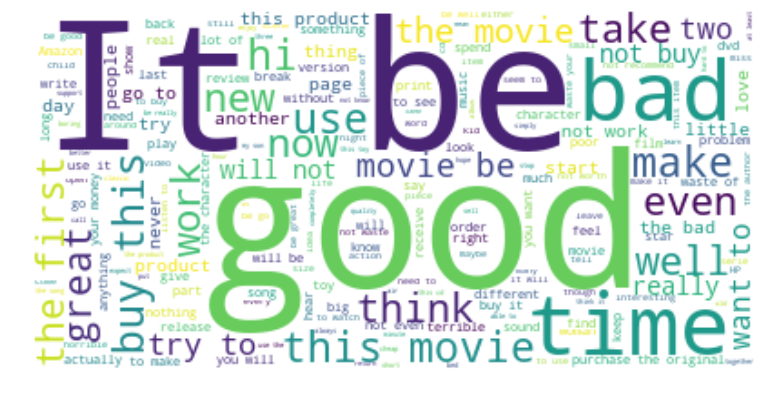

In [25]:
wordcloud3 = WordCloud(stopwords=stopwords, background_color='white').generate(" ".join(df_neg))
plt.figure(1, figsize=(13, 13))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud for the negative reviews was less clear cut with the most prominent words being “time”, “good” and “bad”.

In [26]:
df.to_pickle("./reviews5.pkl")